In [1]:
import xarray as xr
import xesmf as xe
import numpy as np 
import pathlib as pl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches


In [77]:
def swap_dims(ds):
    dsc = ds.copy(deep=False)
    ilat = np.array(range(dsc.lat.shape[0]))
    ilon = np.array(range(dsc.lon.shape[0]))
    dsc['ilat'] = ds['lat']
    dsc['ilon'] = ds['lon']
    dsc['ilat'].values[:] = ilat
    dsc['ilon'].values[:] = ilon
    dsc.swap_dims({"lat":"ilat", "lon":"ilon"})
    return ds



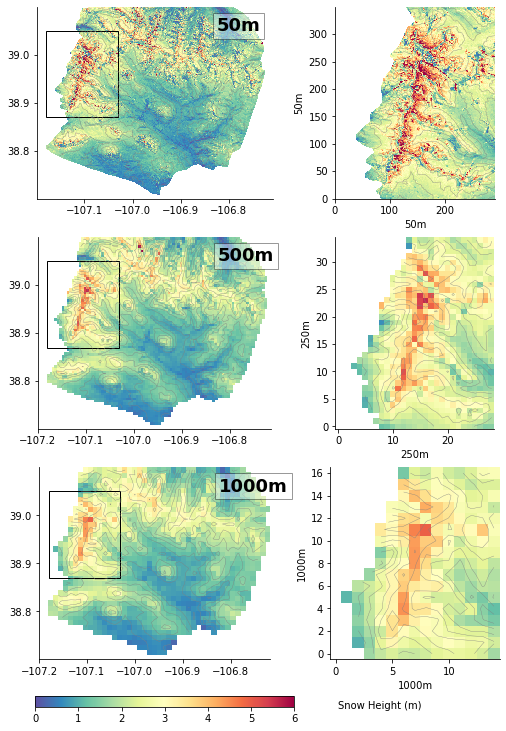

In [250]:
fig,ax = plt.subplots(3,2)
fig.set_size_inches(18,12)

# open depth
dshr = xr.open_dataset("/scratch/wrudisill/EastLSM_Only/most_recent_aso_data/snowdepths/og_grid/ASO_SD_20190407_latlon_clipped.nc")
dshr_dep = dshr.where(dshr.Band1 > 0.)

# open dem 
dem = xr.open_dataset("/scratch/wrudisill/EastLSM_Only/most_recent_aso_data/swedata/og_grid/3mdem_upsample_50m_East_latlon.nc")
dem = dem.where(dem.Band1>0)

# plot the snotel sites...
def label_snotels(ax):
    lats = [38.89,    39.02,   38.99]#,  # 38.95231, 38.9535]
    lons = [-106.95, -107.05, -106.75]#, -106.9856, -106.903]
    names = ["Butte", "Schofield", "UpperTaylor"]# "RMBL_approx", "other"]
    # plot some markers 
    i=0
    for la,lo, in zip(lats,lons):
        ax.scatter(lo, la, marker='D', s=200, color='black')
        ax.text(lo-.02, la+.005,  names[i], size=13, weight='bold')
        i+=1

# slightly tweek the plot to make less white space 
box0_loc={"lat":slice(38.7, 39.1),
          "lon":slice(-107.2, -106.3)}


# plot the 50 depth
foo   = dshr_dep.Band1.sel(box0_loc)
m50   = dshr_dep.Band1.sel(box0_loc)
m250  = dshr_dep.Band1.sel(box0_loc).coarsen(lat=10,lon=10,boundary='trim').mean()
m1000 = dshr_dep.Band1.sel(box0_loc).coarsen(lat=20,lon=20,boundary='trim').mean()

# make the different dems ...
mdem50  = (dem.sel(box0_loc).Band1.values * (foo/foo))
mdem250 = (dem.sel(box0_loc).Band1.values * (foo/foo)).coarsen(lat=10,lon=10,boundary='trim').mean()
mdem1000 = (dem.sel(box0_loc).Band1.values * (foo/foo)).coarsen(lat=20,lon=20,boundary='trim').mean()


# plot the whole maps 
m50.plot(vmin=0, vmax=6,   ax=ax[0,0], cmap='Spectral_r',add_colorbar=False)
m250.plot(vmin=0, vmax=6,  ax=ax[1,0], cmap='Spectral_r',add_colorbar=False)
m1000.plot(vmin=0, vmax=6, ax=ax[2,0], cmap='Spectral_r',add_colorbar=False)

#
ax[0,0].contour(mdem50.lon, mdem50.lat, mdem50.values, colors='gray', linewidths=.35)
ax[1,0].contour(mdem250.lon, mdem250.lat, mdem250.values, colors='gray', linewidths=.35)
ax[2,0].contour(mdem1000.lon, mdem1000.lat, mdem1000.values, colors='gray', linewidths=.35)



# now plot the zoom ins
box_loc={"lat":slice(38.87, 38.87+.18), 
         "lon":slice(-107.18, -107.18+.15)}

## swap the dimensions of the zoom ins .... 
m50x   = dshr_dep.Band1.sel(box0_loc)
m250x  = dshr_dep.Band1.sel(box0_loc).coarsen(lat=10,lon=10,boundary='trim').mean()
m1000x = dshr_dep.Band1.sel(box0_loc).coarsen(lat=20,lon=20,boundary='trim').mean()

# make the different dems ...
mdem50x   = (dem.sel(box0_loc).Band1)
mdem250x  = (dem.sel(box0_loc).Band1).coarsen(lat=10,lon=10,boundary='trim').mean()
mdem1000x = (dem.sel(box0_loc).Band1).coarsen(lat=20,lon=20,boundary='trim').mean()


m50s   = swap_dims(m50x.sel(box_loc))
m250s  = swap_dims(m250x.sel(box_loc))
m1000s = swap_dims(m1000x.sel(box_loc))

mdem50s   = swap_dims(mdem50x.sel(box_loc)) * m50s/m50s
mdem250s  = swap_dims(mdem250x.sel(box_loc)) * m250s/m250s
mdem1000s = swap_dims(mdem1000x.sel(box_loc)) * m1000s/m1000s


# plot the zoom ins 
m50s.plot(vmin=0, vmax=6, ax=ax[0,1], cmap='Spectral_r',add_colorbar=False)
m250s.plot(vmin=0, vmax=6, ax=ax[1,1], cmap='Spectral_r',add_colorbar=False)
p0 = m1000s.plot(vmin=0, vmax=6, ax=ax[2,1], cmap='Spectral_r',add_colorbar=False)

ax[0,1].contour(mdem50s.lon,     mdem50s.lat, mdem50s.values, colors='gray', linewidths=.35)
ax[1,1].contour(mdem250s.lon,    mdem250s.lat, mdem250s.values, colors='gray', linewidths=.35)
ax[2,1].contour(mdem1000s.lon,   mdem1000s.lat, mdem1000s.values, colors='gray', linewidths=.35)



# loop thru the axes...
for axx in ax.flatten():
    for spine in ['right', 'top']: #axx.spines:
        axx.spines[spine].set_visible(False)
    axx.axis('scaled')
    axx.set_xlabel("")
    axx.set_ylabel("")


# add a patch 
def add_patch(axx):    
    rect = patches.Rectangle((-107.18, 38.87), .15, .18, fill=False) #transform=ax.get_transform())
    axx.add_patch(rect)

# loop through 
for i in [0,1,2]:
    add_patch(ax[i,0])
fig.subplots_adjust(wspace=-.65)


#change the ticks 
fwrticks_l = ax[0,0].get_yticks()[2:-2][::2]

# loop thru the rows...
for i in [0,1,2]:
    ax[i,0].set_yticks(fwrticks_l)
    
res = [50., 500., 1000.]
# mark in km
# for i,r in enumerate(res):

#     xticklabels = ((ax[i,1].get_xticks() * r))
#     yticklabels = ((ax[i,1].get_yticks() * r))
    
#     # set the ticklabels in km
#     ax[i,1].set_xticklabels(xticklabels)
#     ax[i,1].set_yticklabels(yticklabels)

# (ax[2,1].get_xticks()*1000).astype("int")/1000

#ax[2,1].set_xticklabels(["0", "1", "2"])

ax[0,1].set_xlabel("50m")
ax[0,1].set_ylabel("50m")

ax[1,1].set_xlabel("250m")
ax[1,1].set_ylabel("250m")

ax[2,1].set_xlabel("1000m")
ax[2,1].set_ylabel("1000m")

# left, bottom, width, height
# cb = fig.add_axes([.685, .662, .0085, .22])
cb = fig.add_axes([.32, .07, .2, .013])
cb.text(7,-1, "Snow Height (m)")
fig.colorbar(p0, cax=cb, orientation='horizontal')

ax[0,0].text(-106.825, 39.05, "50m",   fontsize='18', fontweight='bold', bbox=dict(facecolor='white', alpha=0.4, edgecolor='black'))
ax[1,0].text(-106.825, 39.05, "500m",  fontsize='18', fontweight='bold', bbox=dict(facecolor='white', alpha=0.4, edgecolor='black'))
ax[2,0].text(-106.825, 39.05, "1000m", fontsize='18', fontweight='bold', bbox=dict(facecolor='white', alpha=0.4, edgecolor='black'))

plt.savefig("aso_resolution_plot", facecolor='white', bbox_inches = "tight", dpi=600)


In [128]:
mdem50x   = (dem.sel(box0_loc).Band1.values * (foo/foo))
mdem250x  = (dem.sel(box0_loc).Band1.values * (foo/foo)).coarsen(lat=10,lon=10,boundary='trim').mean()
mdem1000x = (dem.sel(box0_loc).Band1.values * (foo/foo)).coarsen(lat=20,lon=20,boundary='trim').mean()

In [61]:
m50s   = swap_dims(m50.sel(box_loc))
m250s  = swap_dims(m250.sel(box_loc))
m1000s = swap_dims(m1000.sel(box_loc))

In [149]:
(xticklabels/1000).astype("int")

array([-2,  0,  2,  4,  6,  8, 10, 12, 14, 16])

In [51]:
dshr = xr.open_dataset("/scratch/wrudisill/EastLSM_Only/most_recent_aso_data/snowdepths/og_grid/ASO_SD_20190407_latlon_clipped.nc")


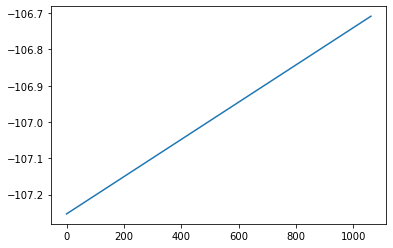

In [44]:
plt.plot(dshr.lon.values)

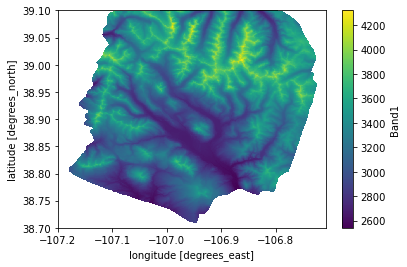

In [89]:
(dem.sel(box0_loc).Band1.values * (m50/m50)).plot()

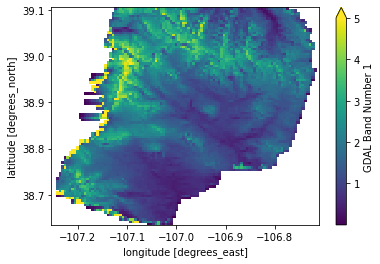

In [29]:
dshr_dep.Band1.coarsen(lat=10,lon=10,boundary='trim').mean().plot(vmax=5)

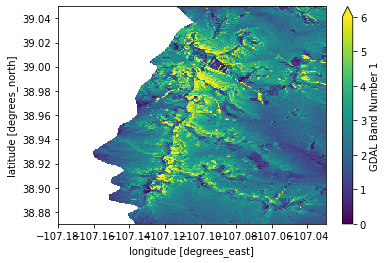

In [40]:
m50.sel(box_loc).plot(vmin=0, vmax=6)


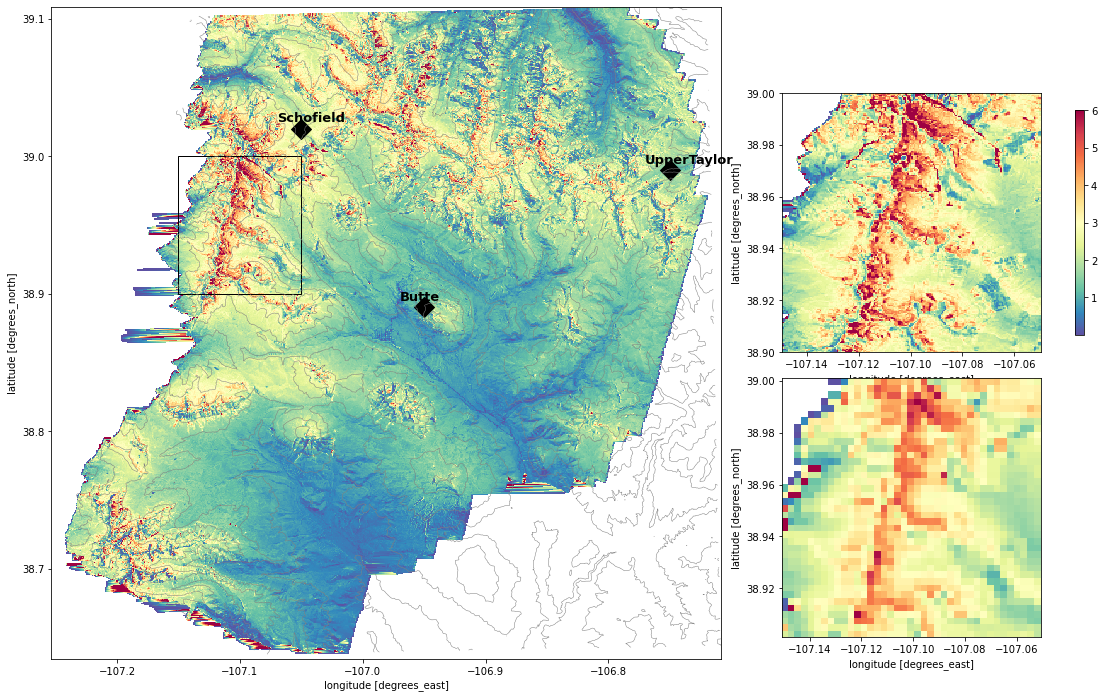

In [9]:
fig,ax = plt.subplots()
fig.set_size_inches(12,12)

dshr_dep.Band1.plot(vmin=0, vmax=6, ax=ax, cmap='Spectral_r',  add_colorbar=False)
#ax.set_xlim(-107.2, -106.74)
#ax.set_ylim(38.77, 39.025)

# left, bottom, width, height
ax2 = fig.add_axes([.97, .48, .3, .3])
ax3 = fig.add_axes([.97, .15, .3, .3])

ax4 = fig.add_axes([1.31, .5, .01, .26])

# # plot the snotel sites...

lats = [38.89,    39.02,   38.99]#,  # 38.95231, 38.9535]
lons = [-106.95, -107.05, -106.75]#, -106.9856, -106.903]

# 38.9535 
# #38.95231455292583, -106.98556315540024
names = ["Butte", "Schofield", "UpperTaylor"]# "RMBL_approx", "other"]

i=0
for la,lo, in zip(lats,lons):
    ax.scatter(lo, la, marker='D', s=200, color='black')
    ax.text(lo-.02, la+.005,  names[i], size=13, weight='bold')
    i+=1
    
clabs = ax.contour(dem.lon, dem.lat, dem.Band1.values, colors='gray', linewidths=.5)
# #plt.clabel(clabs)

# # lat=slice(38.9,39.0), lon=slice(-107.15, -107.095)
#rect = patches.Rectangle((38.9,39.0), 40, 30, linewidth=1, edgecolor='r', facecolor='none')

import matplotlib.patches as patches
rect = patches.Rectangle((-107.15, 38.9), .1, .1, fill=False) #transform=ax.get_transform())


cb = dshr_dep.sel(lat=slice(38.9, 39.0), lon=slice(-107.15, -107.15 + .1)).Band1.plot(vmax=6, cmap='Spectral_r', ax=ax2, add_colorbar=False)


cbact = fig.colorbar(cb, cax=ax4, orientation="vertical")
#cbact.set_label("depth (m)")
dslr_dep.sel(lat=slice(38.9, 39.0), lon=slice(-107.15, -107.15 + .1)).Band1.plot(vmax=6, cmap='Spectral_r', ax=ax3, add_colorbar=False)

# dem_smaller_region = dem.sel(lat=slice(38.9, 39.0), 
#                              lon=slice(-107.15, -107.15 + .1))
                             
# ax2.contour(dem_smaller_region.lon, 
#             dem_smaller_region.lat, 
#             dem_smaller_region.Band1.values, colors='gray', linewidths=.8)

# ax3.contour(dem_smaller_region.lon, 
#             dem_smaller_region.lat, 
#             dem_smaller_region.Band1.values, colors='gray', linewidths=.8)

# for axx in [ax,ax2]:
#     axx.axis('scaled')

# Add the patch to the Axes
ax.add_patch(rect)

#ax.quiver(mp08_2019.XLONG, mp08_2019.XLAT,mp08_2019.U10.mean(dim="XTIME"), mp08_2019.V10.mean(dim="XTIME"), color='gray')

#ax2.quiver(mp08_2019.XLONG, mp08_2019.XLAT, mp08_2019.U10.mean(dim="XTIME"), mp08_2019.V10.mean(dim="XTIME"), scale=100, width=.01)
#ax3.quiver(mp08_2019.XLONG, mp08_2019.XLAT, mp08_2019.U10.mean(dim="XTIME"), mp08_2019.V10.mean(dim="XTIME"), scale=100, width=.01)


In [ ]:
# open up the aspect layer...

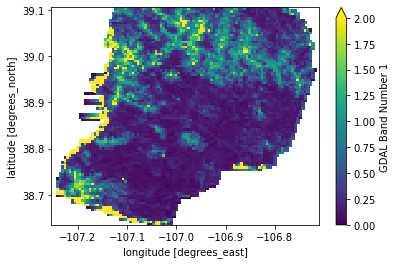

In [24]:
dshr_dep.Band1.coarsen(lat=10, lon=10, boundary='trim').std().plot(vmax=2)

In [21]:
slope = xr.open_dataset("/home/wrudisill/scratch/EastLSM_Only/ASOdata/processed_dems/wgs84_latlon_slope_50m.nc")

In [29]:
# fig,ax = plt.subplots()
# fig.set_size_inches(12,12)
#slope.Band1.plot(vmin=0, vmax=90, ax=ax)

dep_array = dshr_dep.where((dshr_dep.Band1>0)&(dshr_dep.Band1<30)).Band1.values
slp_array = slope.where(slope.Band1 < 20).Band1.values

# get the snowdepths on low slopes 
#    np.where(slp_array<20, dep_array, np.nan)

In [31]:
new_array = np.zeros_like(dep_array)
xl = dep_array.shape[0]
yl = dep_array.shape[0]
search_len = 4 #

for i in range(xl):
    for j in range(yl):
        
        
        

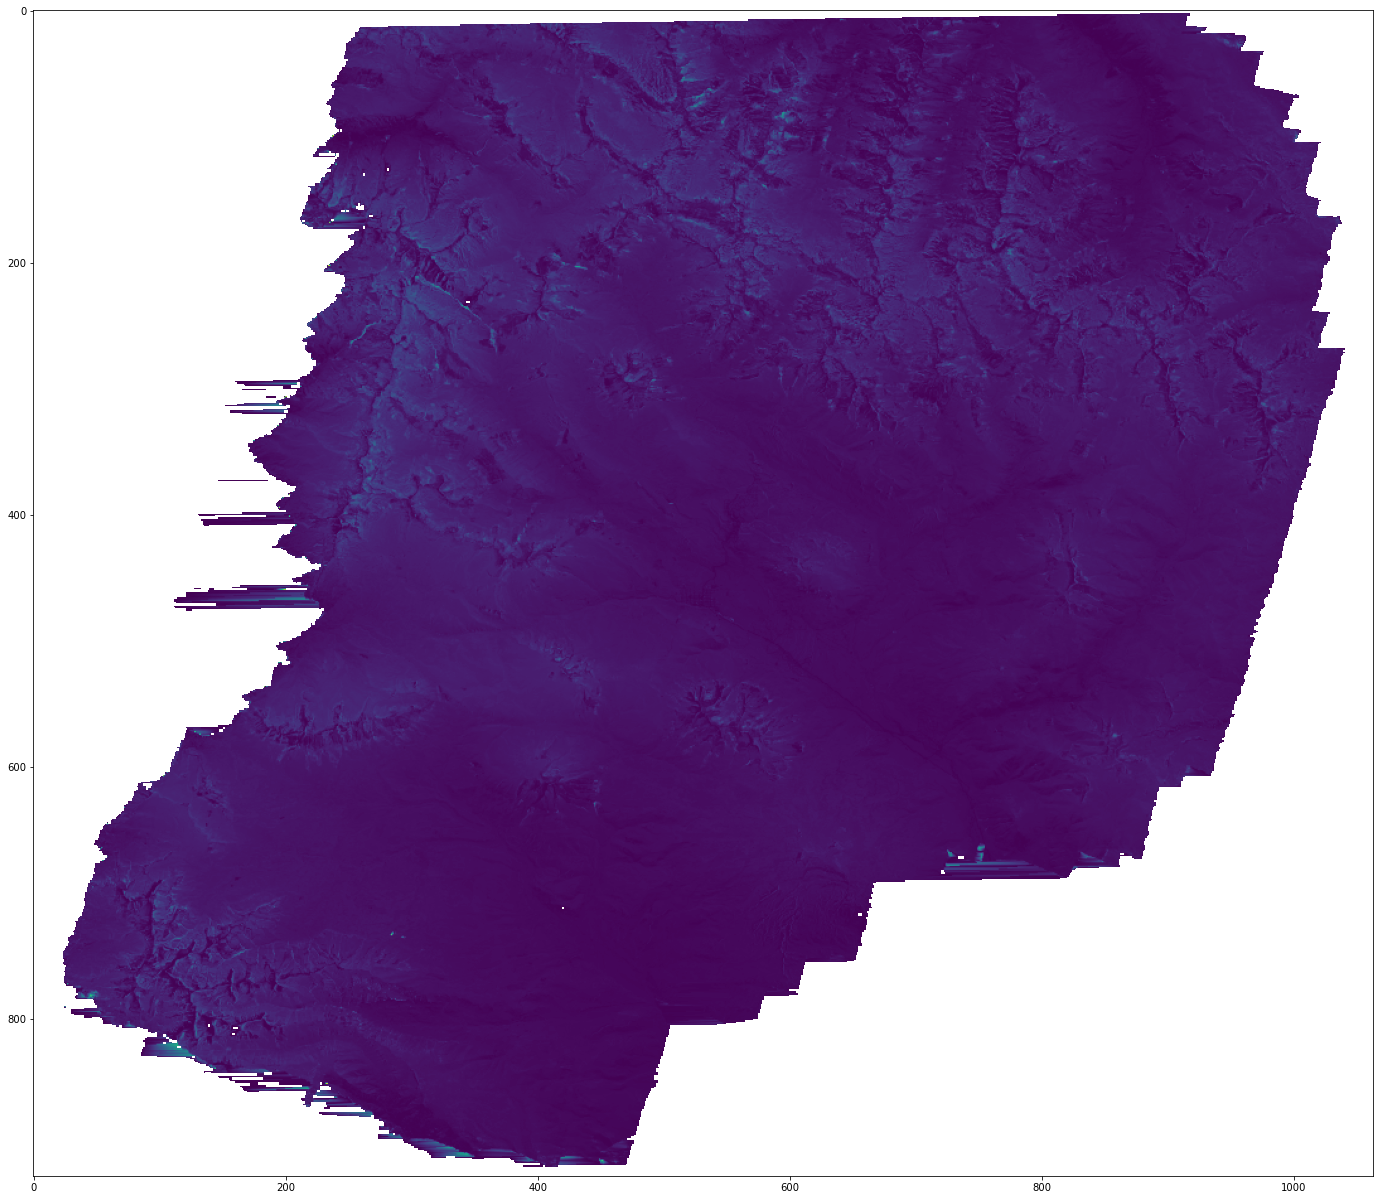

In [32]:
fig,ax=plt.subplots()
fig.set_size_inches(24,24)

ax.imshow(dep_array[::-1,:])#vmax=20)

/home/wrudisill/miniconda3/envs/wrfplotenv/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/wrudisill/miniconda3/envs/wrfplotenv/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


(0.0, 6.0)

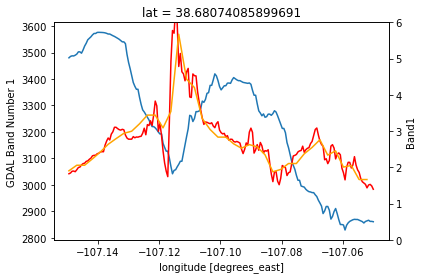

In [14]:
fig,ax = plt.subplots()
ax2 = ax.twinx()
dem.Band1.sel(lon=slice(-107.15, -107.15 + .1)).isel(lat=90).plot(ax=ax)
dshr_dep.Band1.sel(lat=slice(38.93, 38.935)).mean(dim="lat").sel(lon=slice(-107.15, -107.15 + .1)).plot(ax=ax2, color='red')
dslr_dep.Band1.sel(lat=slice(38.93, 38.935)).mean(dim="lat").sel(lon=slice(-107.15, -107.15 + .1)).plot(ax=ax2, color='orange')
ax2.set_ylim(0,6)

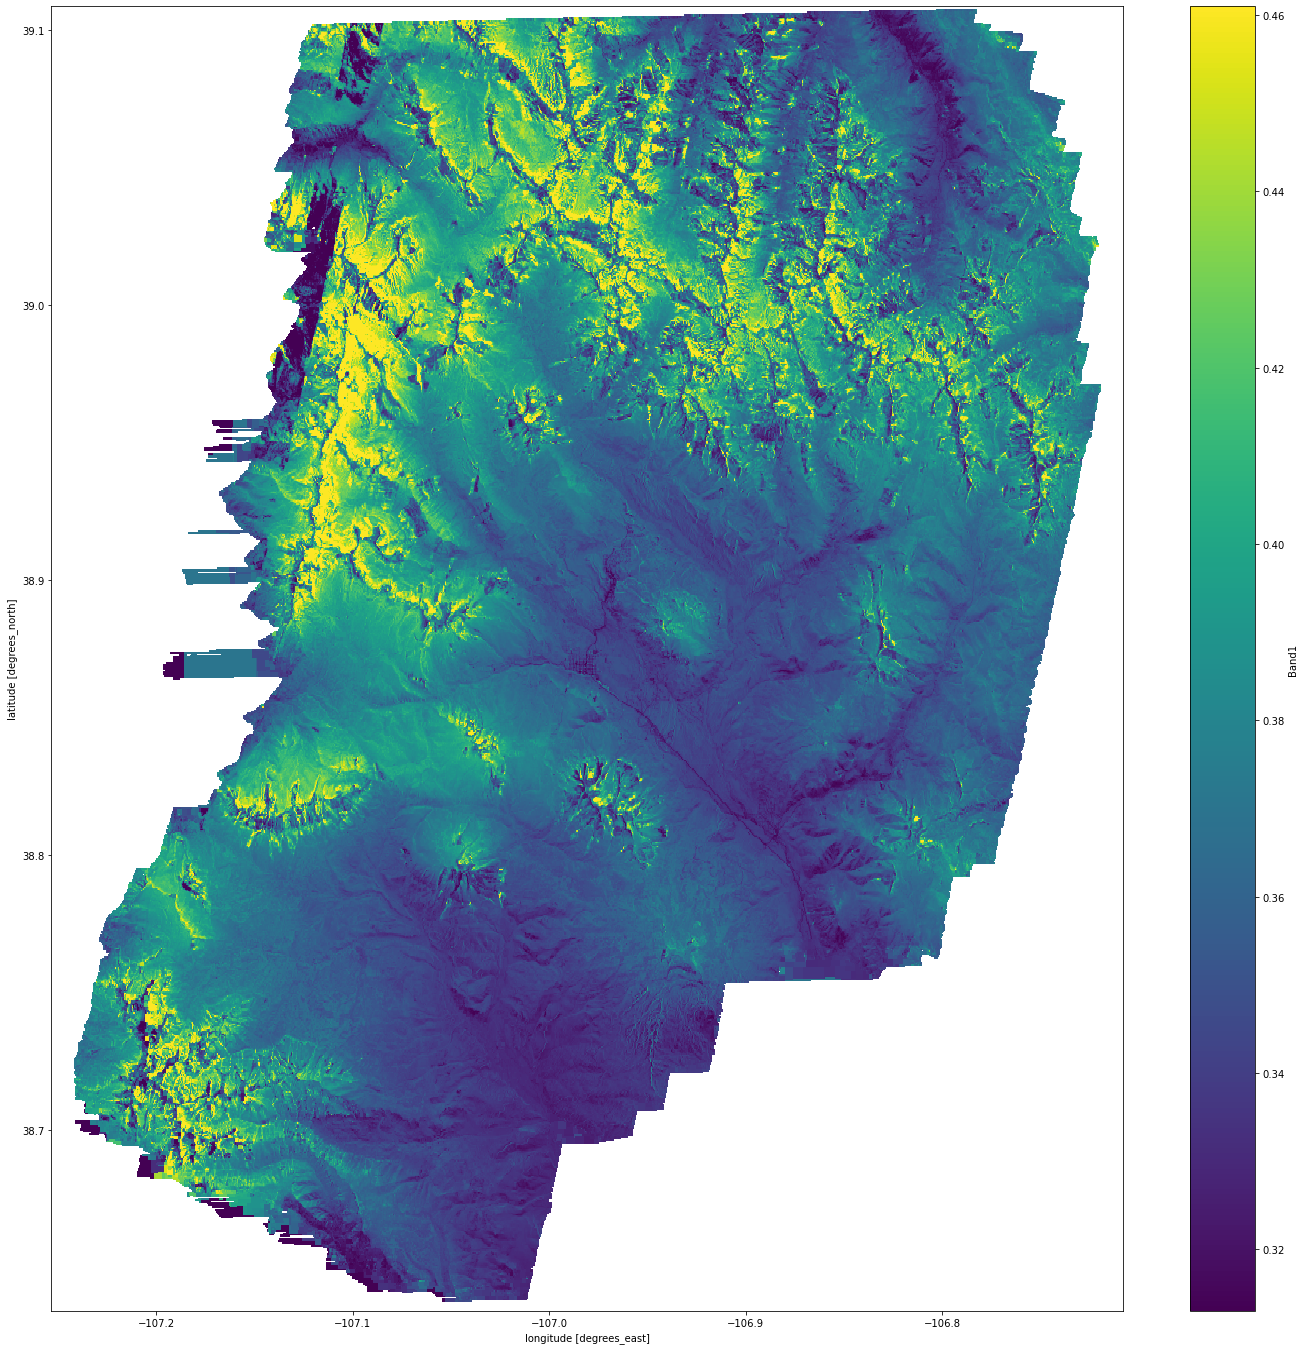

In [70]:
fig,ax = plt.subplots()
fig.set_size_inches(24,24)
(dshr.Band1/dshr_dep.Band1).plot()

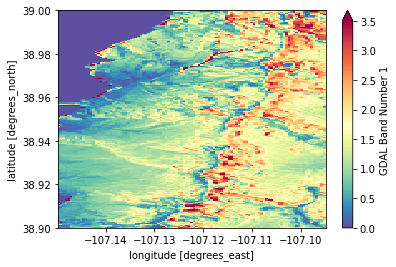

In [44]:
dshr.sel(lat=slice(38.9,39.0), lon=slice(-107.15, -107.095)).Band1.plot(vmax=3.5, cmap='Spectral_r')



In [136]:
dslr.sel(lat=slice(38.9,39.0), lon=slice(-107.15, -107.095)).Band1.plot(vmax=3.5, cmap='Spectral_r')

IndexError: index -1 is out of bounds for axis 0 with size 0

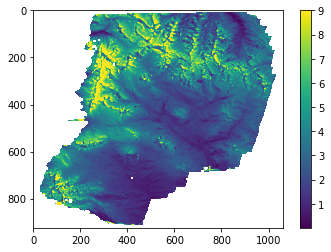

In [30]:
from scipy.ndimage import correlate

weights = [[0, 1, 0],
           [1, 1, 1],
           [0, 1, 0]]

plt.imshow(correlate(dshr.Band1.values, weights)[::-1,:],vmax=9)
plt.colorbar()